Tyfenn Eloy  
Mathias Berthonneau  
Arthur-Louis Bonneau  
Loris Nezan

<h1 style="text-align:center">Process Mining</h1>
<h2 style="text-align:center">Project - Study of potential bias in the rental process</h2>

In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
log_low = pm4py.read_xes('data/renting_log_low.xes')
log_medium = pm4py.read_xes('data/renting_log_medium.xes')
log_high = pm4py.read_xes('data/renting_log_high.xes')

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:04<00:00, 2295.83it/s]
/home/loris/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/loris/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/loris/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please 

In [24]:
log_low.columns

Index(['activity', 'resource', 'time', 'concept:name', 'time:timestamp',
       '@@index', 'case:concept:name', 'case:german speaking',
       'case:yearsOfEducation', 'case:age', 'case:gender', 'case:citizen',
       'case:protected', 'case:married', 'case:@@case_index', 'case:case'],
      dtype='object')

## General trace analysis

In [25]:
CASE_ID_COL = 'concept:name'
ACTIVITY_COL = 'activity'
TIMESTAMP_COL = 'time:timestamp'

print(f"Case ID Column: {CASE_ID_COL}")
print(f"Activity Column: {ACTIVITY_COL}")
print(f"Timestamp Column: {TIMESTAMP_COL}")

Case ID Column: concept:name
Activity Column: activity
Timestamp Column: time:timestamp


Statistics for the `low` dataset:

In [26]:
num_cases = len(log_low.groupby(CASE_ID_COL))
num_events = len(log_low)

variants = pm4py.get_variants(log_low)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 96440
Number of variants: 508


Statistics for the `medium` dataset:

In [27]:
num_cases = len(log_medium.groupby(CASE_ID_COL))
num_events = len(log_medium)

variants = pm4py.get_variants(log_medium)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 105555
Number of variants: 610


Statistics for the `high` dataset:

In [28]:
num_cases = len(log_high.groupby(CASE_ID_COL))
num_events = len(log_high)

variants = pm4py.get_variants(log_high)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 89972
Number of variants: 496


The general statistics of the different datasets are similar in term of size. We will be able to compare them easily.

## Drawing a general diagram of the flow

In [29]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

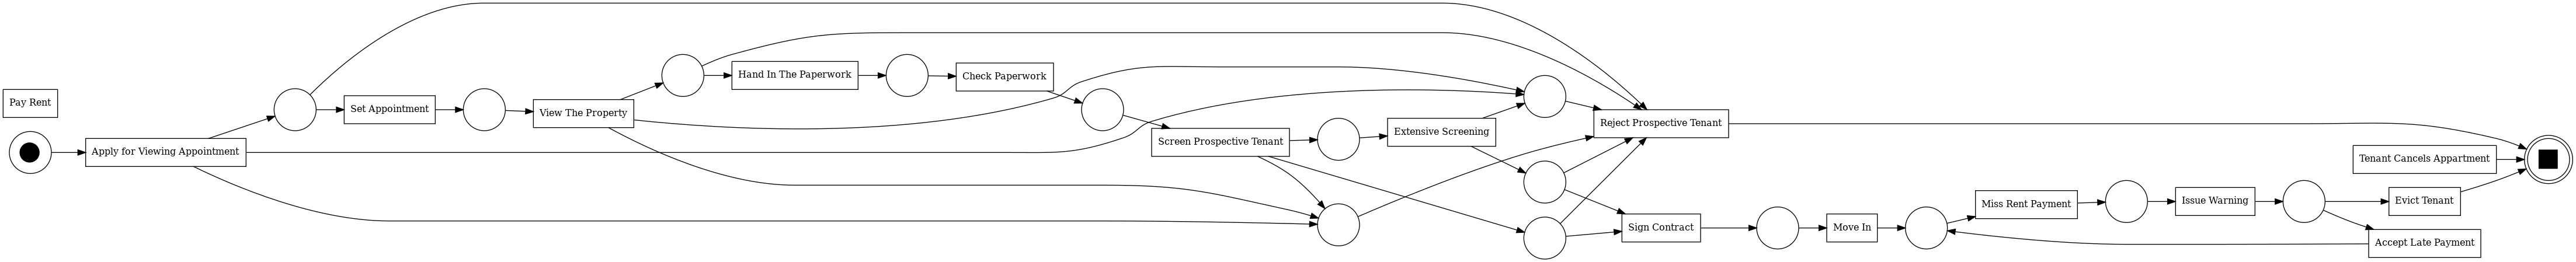

In [30]:
net, initial_marking, final_marking = alpha_miner.apply(log_low)

pm4py.view_petri_net(net, initial_marking, final_marking)

In the renting process, we can identify 4 main steps:

- The user is applying for a place
- The landlord is accepting or rejecting the application
- The user is paying the rent or not
- The user can get evicted or not

Based on this, we can look for potential bias in the process regarding the additional information we have on the users :

- Age
- Education
- Gender
- Citizenship
- Life situation (marriage, single)

/home/loris/.local/lib/python3.10/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


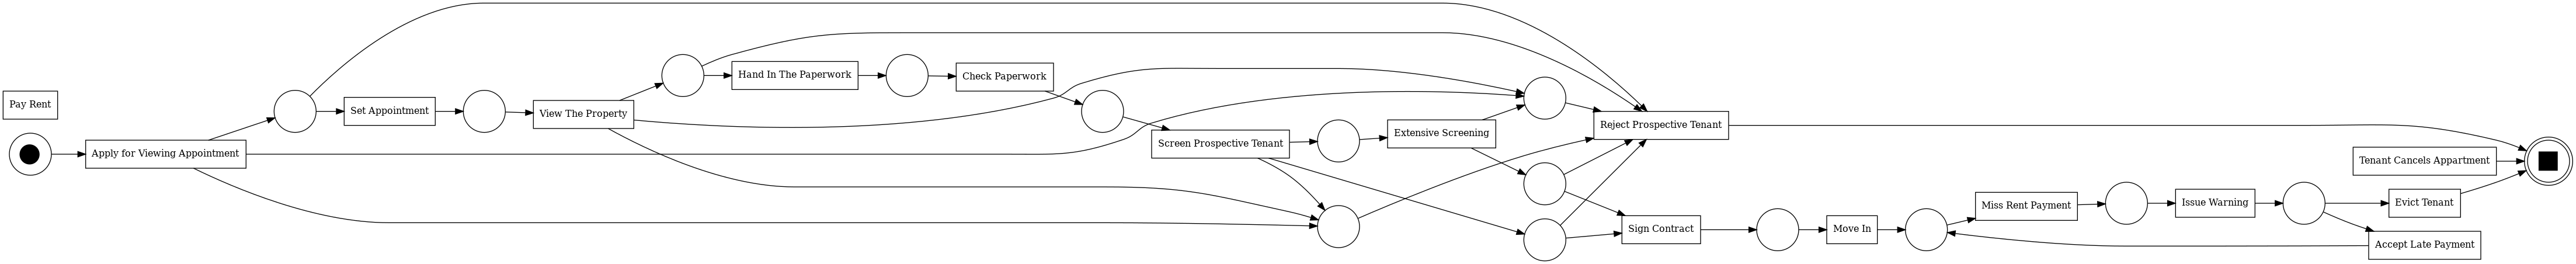

In [31]:
# split per "case:age"
log_young_low = log_low[log_low['case:age'] < 25]
log_middle_low = log_low[(log_low['case:age'] >= 25) & (log_low['case:age'] <= 50)]
log_old_low = log_low[log_low['case:age'] > 50]

net, initial_marking, final_marking = alpha_miner.apply(log_old_low)
pm4py.view_petri_net(net, initial_marking, final_marking)

/home/loris/.local/lib/python3.10/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


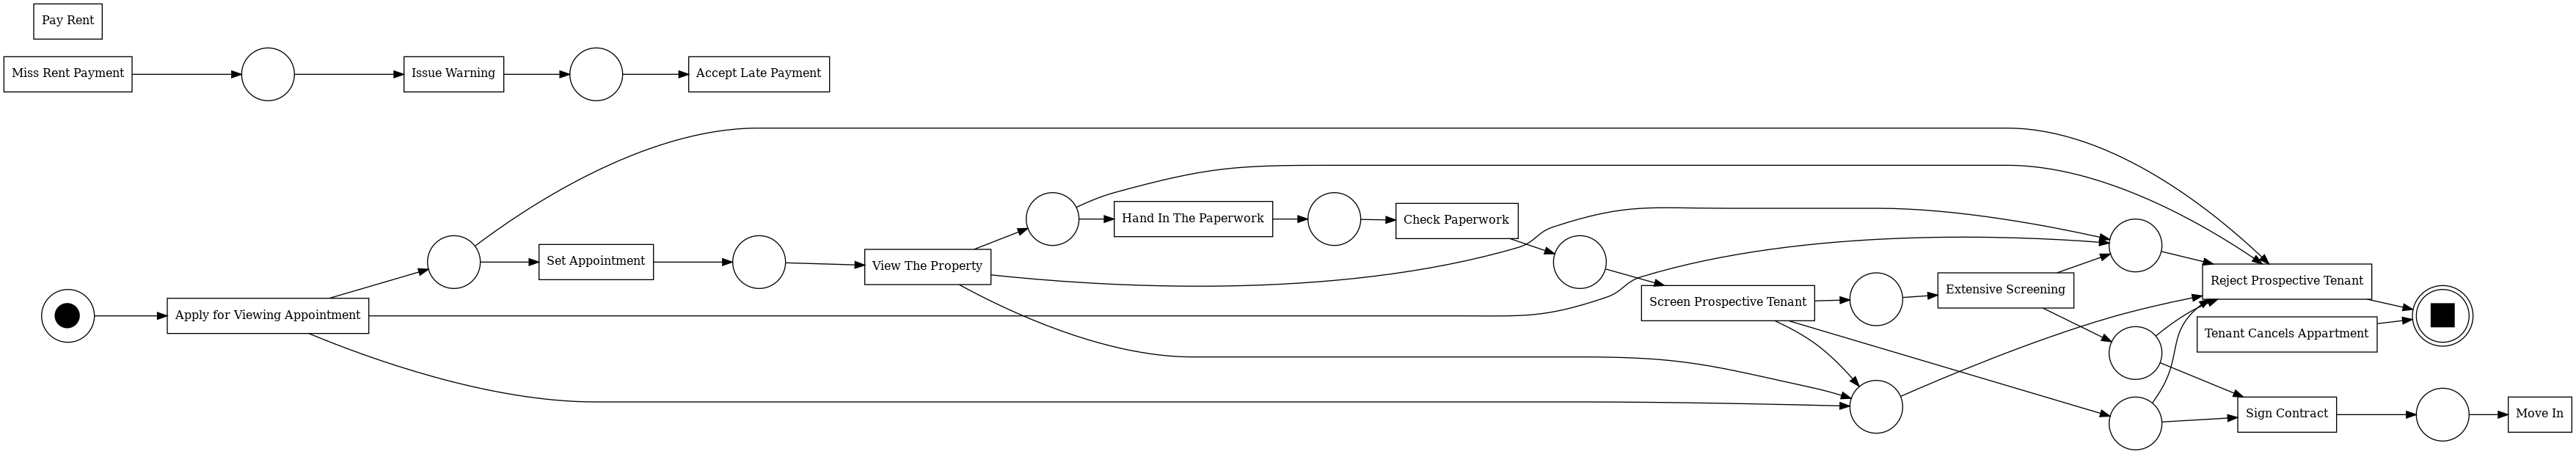

In [32]:
# split per "case:yearsOfEducation"

log_uneducated_low = log_low[log_low['case:yearsOfEducation'] < 5]
log_medium_education_low = log_low[(log_low['case:yearsOfEducation'] >= 5) & (log_low['case:yearsOfEducation'] <= 15)]
log_high_education_low = log_low[log_low['case:yearsOfEducation'] > 16]

net, initial_marking, final_marking = alpha_miner.apply(log_high_education_low)
pm4py.view_petri_net(net, initial_marking, final_marking)